#### Problem Statement -
Build your own recommendation system for products on an e-commerce website like Amazon.com.


Dataset - ​ Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) ratings_Electronics_Ver3.tar.xz (you may use winrar application to extract the .csv file)

Dataset Link: https://drive.google.com/open?id=1zY_xSowvlliih4hfKHw0eu9pbSEIC8HX

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.


o The repository has several datasets. For this case study, please use the Electronics dataset.
o The host page has several pointers to scripts and other examples that can help with parsing the datasets.
o The data set consists of:
● 7,824,482 Ratings (1-5) for Electronics products.
● Other metadata about products. Please see the description of the fields available on the web page cited above.


o For convenience of future use, parse the raw data file (using Python, for example) and extract the following fields: 'product/productId' as prod_id, 'product/title' as prod_name, 'review/userId' as user id, 'review/score' as rating
o Save these to a tab separated file. Name this file as product_ratings.csv.

Steps -
1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )
3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model.
6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.
8. Summarise your insights.

Mark Distributions -
Step - 1,2,3,8 - 5 marks each
Step - 4,5,6,7 - 10 marks each

### Import the library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import Recommenders as Recommenders
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
# load the dataset
df = pd.read_csv('ratings_Electronics.csv')

In [5]:
# get top 5 Dataset
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
# Name the column
df.columns = ['user_id', 'productId','ratings','timestamp']

In [7]:
# After renaming the column, get top 5 dataset
df.head()

,user_id,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
# get the shape of the dataframe
df.shape

(7824481, 4)

In [9]:
# get the summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
user_id      object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [10]:
# drop timestamp, as it doesn't going to pla any signifcant role in deciding recommentation
df = df.drop('timestamp', axis=1)

In [11]:
# Get the head of the DataFrame after droping timestamp column
df.head()

,user_id,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [12]:
# After droping the column, shape of the DataFrame will be change
df.shape

(7824481, 3)

In [13]:
# Check for missing values
df.isnull().sum()

user_id      0
productId    0
ratings      0
dtype: int64

### <font color="magenta">None of the records have missing values

### Glance summary statistics

In [14]:
# Generates descriptive statistics that summarize the central tendency,dispersion and shape of a dataset's distribution
df.describe()

,ratings
count,7.824481e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


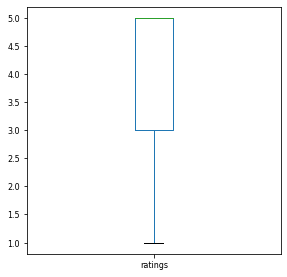

In [15]:
# Draw box plot to see the outliers
df.plot(kind='box',figsize=(10,10),subplots=True, layout=(2,2),fontsize=8)
plt.show()

### <font color="red">From the descriptive statistics analysis of the data shows clearly that there are no outliers.The same has been verified from the Box plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21f68f98>]],
      dtype=object)

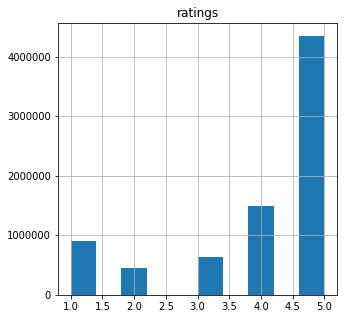

In [16]:
# Make a histogram of the DataFrame
df.hist(figsize=(5,5))

In [17]:
# utilify function for % distribution
def category_distribution(df, colname):
    col_data = df[colname].value_counts().to_frame()
    col_data.reset_index(inplace=True)
    col_data.columns = [col_data.columns[1], 'count']
    col_data['proportions'] = col_data['count'] / sum(col_data['count'])
    print("\n % Distribution for: ",colname)
    print(col_data)
    return

In [18]:
# analysising % distribution of Rating columns
category_distribution(df, "ratings")


 % Distribution for:  ratings
   ratings    count  proportions
0      5.0  4347540     0.555633
1      4.0  1485781     0.189889
2      1.0   901765     0.115249
3      3.0   633073     0.080909
4      2.0   456322     0.058320


### Observation on Rating distribution
Rating 5 has been given highest number of times. Infact rating 5 cover approx 55% of dataset.

In [19]:
# get unique counts of userId counts
df.user_id.value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A38RMU1Y5TDP9     282
A3EXWV8FNSSFL6    282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A231WM2Z2JL0U3    252
A12DQZKRKTNF5E    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
A203OCQQ12MAVT    240
AEJAGHLC675A7     239
A2NYK9KWFMJV4Y    238
A3A4ZAIBQWKOZS    236
A1T1YSCDW0PD25    227
                 ... 
A4TS9WORVD7FX       1
A2IZDZMOIKLPQS      1
A1B42A4W0K0CRH      1
A9J5IUM2ROJF7       1
A2YTYYQREXKP9G      1
AS8HOADB81277       1
AX3305RKV9K0Y       1
AIKO1NOXU3XDH       1
A2GJD7LHHI0OIA      1
AISLD9MM4VXVC       1
A3QPT6XRH5NATL      1
A1PUEP3DSHWCQN      1
A2NVIR54J1FECP      1
A1ZNHQ0KLAY50L      1
A3RT1A2R1X

In [20]:
# Get the user only who has given 50 or more number of ratings
df_gt50 = df[df.groupby('user_id')['user_id'].transform('size') >= 50]

In [21]:
# Get the shape after filtering on userId >= 50
df_gt50.shape

(125871, 3)

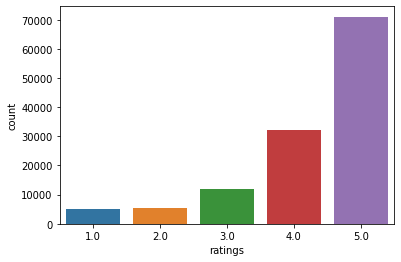

In [22]:
# plotting count of Rating
sns.countplot(data=df_gt50 , x='ratings')
plt.show()

### Showing the most popular products in the dataset

In [23]:
product_grouped = df_gt50.groupby(['productId']).agg({'ratings': 'count'}).reset_index()
grouped_sum = product_grouped['ratings'].sum()
product_grouped['percentage']  = product_grouped['ratings'].div(grouped_sum)*100
product_grouped.sort_values(['ratings', 'productId'], ascending = [0,1])

,productId,ratings,percentage
39003,B0088CJT4U,206,0.163660
24827,B003ES5ZUU,184,0.146181
11078,B000N99BBC,167,0.132676
38250,B007WTAJTO,164,0.130292
38615,B00829TIEK,149,0.118375
38611,B00829THK0,137,0.108842
39338,B008DWCRQW,137,0.108842
21982,B002R5AM7C,128,0.101691
28761,B004CLYEDC,118,0.093747
22210,B002SZEOLG,113,0.089774


In [24]:
# Get unique user in the dataset
users = df_gt50.user_id.unique()

In [25]:
print("Unique users: ", len(users))

Unique users:  1540


In [26]:
# get unique product in the dataset
print("Unique Product: ", len(df_gt50.productId.unique()))

Unique Product:  48190


### Split the data randomly into train and test dataset in 70:30 ratio

In [27]:
#train_data, test_data = train_test_split(df_gt50, test_size = 0.30, random_state=0)
trainDF, tempDF = train_test_split(df_gt50, test_size=0.3, random_state=0)

#creating a copy of tempDF as testDF
testDF = tempDF.copy()

#Assigning ratings of tempDF to nan
tempDF.ratings = np.nan

#Creating ratings with trainDF and tempDF
#df_ratings = pd.concat([trainDF, tempDF]).reset_index()
df_ratings = pd.concat([trainDF, tempDF])
print("Shape:" ,df_gt50.shape)
df_ratings.head()

#print(train_data.head(5))

Shape: (125871, 3)


//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,user_id,productId,ratings
6595852,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738240,AB094YABX21WQ,B0056XCEAA,1.0
4175595,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753015,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734766,A1NNMOD9H36Q8E,B0015VW3BM,4.0


#### <font color="green">Build Popularity Recommender model.

In [28]:
# making format of ratings matrix to be one row per user and one column per product. 
# Fill not available values as 0.0 - sprase martix
# since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
ratings_matrix = df_ratings.pivot(index = 'user_id', columns ='productId', values = 'ratings').fillna(0)
userID = ratings_matrix.index
productID = ratings_matrix.columns
ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Normalize the ratings using StandardScaler
scaler = StandardScaler()
ratings_matrix_std = scaler.fit_transform(ratings_matrix)

In [30]:
# Consider all the mean ratings of each product and find the product with highest mean value
# display the top 10 ProductIDs.
df_mean = pd.DataFrame(ratings_matrix_std).mean(axis=0)
mean_df_sorted = df_mean.sort_values(ascending=False)
mean_df_sorted.head() # this diaplay column index for the product with popularity

34919    2.069358e-15
31662    1.944846e-15
16089    1.943566e-15
25511    1.915225e-15
39197    1.714078e-15
dtype: float64

In [31]:
# lets display the top 10 product with thier "ProductID" and rating
df_porpularity = pd.DataFrame({"ProductID": productID[mean_df_sorted.index], "MeanRating": mean_df_sorted.values})

In [32]:
print("\nPopularity model with overall top 10 products: ")
df_porpularity.head(10)


Popularity model with overall top 10 products: 


,ProductID,MeanRating
0,B005VAORH6,2.069358e-15
1,B004YIFKRM,1.944846e-15
2,B001C6IWME,1.943566e-15
3,B003LSTD3I,1.915225e-15
4,B008BH5D6K,1.714078e-15
5,B00BBD7NFU,1.639165e-15
6,B008R91OZ6,1.509858e-15
7,B00932N46S,1.436036e-15
8,B000095SB6,1.397881e-15
9,B009H0XQPU,1.365295e-15


In [33]:
# Get top 5 recommendations for user not already rated by that user
def pm_recommend(pop_model, dataset, userid, k=5):
    user_product = dataset[dataset.user_id == userid]
    print ('User {0} has already rated {1} movies.'.format(userid, user_product.shape[0]))
    user_rec = pop_model[~pop_model['ProductID'].isin(user_product['productId'])]
    return user_rec.head(k)

In [34]:
df_gt50.columns

Index(['user_id', 'productId', 'ratings'], dtype='object')

In [35]:
# Get top 10 recommendations for user not already rated by that user
num_recommendations = 10
userid = userID[0]

#  Get top 10 recommendations for user not already rated by that user
user_rec = pm_recommend(df_porpularity, df_ratings, userid, 10)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

User A100UD67AHFODS has already rated 116 movies.
Top 10 recomendation for user: A100UD67AHFODS
    ProductID    MeanRating
0  B005VAORH6  2.069358e-15
1  B004YIFKRM  1.944846e-15
2  B001C6IWME  1.943566e-15
3  B003LSTD3I  1.915225e-15
4  B008BH5D6K  1.714078e-15
5  B00BBD7NFU  1.639165e-15
6  B008R91OZ6  1.509858e-15
7  B00932N46S  1.436036e-15
8  B000095SB6  1.397881e-15
9  B009H0XQPU  1.365295e-15


### <font color="red">Build Collaborative Filtering model.

In [36]:
# making format of ratings matrix to be one row per user and one column per product. 
# Fill not available values as 0.0 - sprase martix
# since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
ratings_matrix = df_ratings.pivot(index = 'user_id', columns ='productId', values = 'ratings').fillna(0)
userID = ratings_matrix.index
productID = ratings_matrix.columns
print("Shape: ", ratings_matrix.shape)
ratings_matrix.head()

Shape:  (1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
print("ratings_matrix Shape: ", ratings_matrix.shape)

ratings_matrix Shape:  (1540, 48190)


In [38]:
from scipy.sparse.linalg import svds
# singluar value decomposition
# Compute the largest k singular values/vectors for a sparse matrix.
# k: Number of singular values and vectors to compute. Must be 1 <= k < min(rating_matrix.shape)
# rating_matrix is to compute the SVD on
# The singular values - sigma
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [39]:
print("U shape: ", U.shape)
print("sigma shape: ", sigma.shape)
print("Vt shape: ", Vt.shape)

U shape:  (1540, 50)
sigma shape:  (50,)
Vt shape:  (50, 48190)


In [40]:
sigma = np.diag(sigma)

# also need to add the user means back to get the predicted ratings
# np.dot - Dot product of two arrays
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [41]:
#predictions of product ratings
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.006449,0.011359,0.002526,-0.023077,0.012542,0.0,0.005729,0.003467,0.007798,0.0,...,-0.000508,-0.055753,0.0,-0.056194,0.028920,0.010719,0.0,0.009238,0.072643,0.0
1,0.000341,-0.008088,-0.000062,0.164734,-0.004147,0.0,0.062662,0.001997,0.040758,0.0,...,-0.001326,0.111041,0.0,0.028977,0.004215,-0.003607,0.0,-0.052556,-0.012128,0.0
2,-0.003762,-0.003616,-0.000269,0.054008,0.004707,0.0,-0.017333,0.005324,-0.007413,0.0,...,-0.001683,0.077804,0.0,0.010742,-0.003366,-0.002317,0.0,0.107837,-0.049954,0.0
3,0.002186,0.009978,0.000374,0.005978,0.006280,0.0,-0.000924,0.002867,0.006295,0.0,...,0.000692,-0.040629,0.0,-0.033066,-0.007107,0.002609,0.0,-0.006263,-0.012567,0.0
4,0.001116,0.002455,0.000453,0.020512,0.012996,0.0,0.006315,0.008417,0.004740,0.0,...,-0.000916,0.013575,0.0,-0.007191,-0.032218,0.003134,0.0,0.090971,0.007914,0.0


In [42]:
def cf_recommend(cb_model, dataset, userid, users, k=5):
    # get the row number from userid
    user_row_number = users.get_loc(userid)    
    # Get and sort the user's predictions
    sorted_user_predictions = cb_model.iloc[user_row_number].sort_values(ascending=False)
    df_sorted_user_pred = pd.DataFrame(sorted_user_predictions).reset_index() 
    df_sorted_user_pred.rename(columns={user_row_number: "Prediction"}, inplace=True)
    user_product = dataset[dataset.user_id == userid]## list of product already rated by users
    print ('User {0} has already rated {1} movies.'.format(userid, user_product.shape[0]))
    user_rec = df_sorted_user_pred[~df_sorted_user_pred["productId"].isin(user_product["productId"])]
    return user_rec.head(k)

In [43]:
num_recommendations = 10
userid = userID[0]

#  Get top 10 recommendations for user not already rated by that user
user_rec = cf_recommend(preds_df, df_ratings, userid, userID, num_recommendations)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

User A100UD67AHFODS has already rated 116 movies.
Top 10 recomendation for user: A100UD67AHFODS
     productId  Prediction
0   B0019EHU8G    1.047999
1   B001E1Y5O6    0.940589
5   B007OY5V68    0.621105
7   B000JMJWV2    0.562749
8   B002V88HFE    0.526831
9   B001TH7GUU    0.508567
10  B004T9RR6I    0.505859
11  B0088CJT4U    0.493607
13  B001F7AJKI    0.484724
14  B005HMKKH4    0.466558


### <font color="blue">Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [44]:
# Temporary dataframe for predicting rating of each user and its product for test cases
# Evaluate Popularity model: calculating RSME on test data
df_final_pm = testDF.copy(deep=True)
df_final_pm["MeanRating"] = 0
df_final_pm.head()

,user_id,productId,ratings,MeanRating
6730390,A3JU990UTN5RQP,B009UHO1L8,5.0,0
3509542,A2VJ5ALN1BIV3B,B003PNIQCI,5.0,0
169752,A2NQMVTQ4PVLL,B00006B7DA,4.0,0
7637571,A25UZ7MA72SMKM,B00FH66AW4,4.0,0
5490139,A680RUE1FDO8B,B006UAJ690,5.0,0


In [45]:
# get mean rating for product - Popularity model
# pm_model: contains predicted rating all products
# productid: product name for which predited rating is calculated
def pm_get_predicted_rating(pm_model, productid):
    rating = pm_model[pm_model.ProductID == productid].iloc[0,1]
    return rating

# finding predicted rating for user and its prodcut for test cases - colaboratibe filtering
def pm_transform_row(r):
    global df_porpularity
    r.MeanRating = pm_get_predicted_rating(df_porpularity, r.iloc[1])
    return r

In [46]:
df_final_pm = df_final_pm.apply(pm_transform_row, axis=1)
df_final_pm.head()

,user_id,productId,ratings,MeanRating
6730390,A3JU990UTN5RQP,B009UHO1L8,5.0,0.000000e+00
3509542,A2VJ5ALN1BIV3B,B003PNIQCI,5.0,0.000000e+00
169752,A2NQMVTQ4PVLL,B00006B7DA,4.0,5.255987e-16
7637571,A25UZ7MA72SMKM,B00FH66AW4,4.0,8.546915e-16
5490139,A680RUE1FDO8B,B006UAJ690,5.0,0.000000e+00


In [49]:
import math

# Let calculate the RMSE
# calculating sum of squared errors for predicted and actual for test data 
mse = np.mean((df_final_pm["ratings"]-df_final_pm["MeanRating"])**2)

# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
pm_rmse = math.sqrt(mse)

print("RMSE for Popularity model: ", pm_rmse)

RMSE for Popularity model:  4.393762400541652


### <font color="blue">Evaluate Colaborative filtering model: calculating RSME on test data

In [50]:
# Temporary dataframe for predicting rating of each user and its product for test cases
df_final_cf = testDF.copy(deep=True)
df_final_cf["PredRating"] = 0
df_final_cf.head()

,user_id,productId,ratings,PredRating
6730390,A3JU990UTN5RQP,B009UHO1L8,5.0,0
3509542,A2VJ5ALN1BIV3B,B003PNIQCI,5.0,0
169752,A2NQMVTQ4PVLL,B00006B7DA,4.0,0
7637571,A25UZ7MA72SMKM,B00FH66AW4,4.0,0
5490139,A680RUE1FDO8B,B006UAJ690,5.0,0


In [51]:
# get rating for user and its product - Colaborative filtering
# df_model: contains predicted rating matrix for users and all products
# users: unique users for knowing its row indexs in df_model
# products: unique products for know it column indexs in df_model
# userid: user name
# productid: product name
def cf_get_predicted_rating(cf_model, users, products, userid, productid):
    user_row_number = users.get_loc(userid)
    product_col_number = products.get_loc(productid)
    rating = cf_model.iloc[user_row_number, product_col_number]
    return rating

# finding predicted rating for user and its prodcut for test cases - colaboratibe filtering
def cf_transform_row(r):
    global preds_df
    global userID
    r.PredRating = cf_get_predicted_rating(preds_df, userID, productID, r.iloc[0], r.iloc[1])
    return r

In [52]:
df_final_cf = df_final_cf.apply(cf_transform_row, axis=1)

In [53]:
df_final_cf.head()

,user_id,productId,ratings,PredRating
6730390,A3JU990UTN5RQP,B009UHO1L8,5.0,0.000000
3509542,A2VJ5ALN1BIV3B,B003PNIQCI,5.0,0.000000
169752,A2NQMVTQ4PVLL,B00006B7DA,4.0,0.087267
7637571,A25UZ7MA72SMKM,B00FH66AW4,4.0,0.298827
5490139,A680RUE1FDO8B,B006UAJ690,5.0,0.000000


In [55]:
import math

# Let calculate the RMSE
# calculating sum of squared errors for predicted and actual for test data 
mse = np.mean((df_final_cf["ratings"]-df_final_cf["PredRating"])**2)

# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
cf_rmse = math.sqrt(mse)

In [56]:
print("RMSE for Popularity model: %0.4f" %(pm_rmse))
print("RMSE for Colaborative filtering model:  %0.4f" %(cf_rmse))

RMSE for Popularity model: 4.3938
RMSE for Colaborative filtering model:  4.3430


### <font color="red">Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [57]:
num_recommendations = 5
userid_index = 4  # 0~1539 (there are 1540 unique users)
userid = userID[userid_index]

#  colaborative filtering: Get top 10 recommendations for user not already rated by that user
user_rec = cf_recommend(preds_df, df_ratings, userid, userID, num_recommendations)

print("Top %d recomendation for user: %s" %(num_recommendations, userid))
print(user_rec)

User A10AFVU66A79Y1 has already rated 65 movies.
Top 5 recomendation for user: A10AFVU66A79Y1
    productId  Prediction
3  B0074BW614    0.454575
4  B00834SJNA    0.419590
5  B008X9ZBVI    0.355165
6  B005HMKKH4    0.354802
7  B004CLYEDC    0.340120


### Summarise

After Evaluating accuracy by comparing the predicted ratings directly with the actual user rating using RMSE, it is observed that Colaborative filtering model lead to lower RMSE than popularity model and hence better modle for this case study